<a href="https://colab.research.google.com/github/danielkorat/dynamic_ds/blob/main/Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm
from collections import defaultdict
from numpy import log
import numpy as np

from nlp.dataset import plot_frequencies, plot_roc, save_ngram_counts, DS_KWARGS
from nlp.model import train_simple_model
from count_min_param import CountMinEvaluation
from cutoff_count_min_param import LearnedCountMinEvaluation
from plotting.plot_loss_vs_space import PlotLossVsSpace
from torch.optim import Adam

In [10]:
DS_NAME = 'wikicorpus'
LIMIT_PROP = 0.001
prec = LIMIT_PROP * 100

DS_ITEM_COUNTS_PATH = f"nlp/data/{prec}%_wikicorpus_2-grams.npz"

config={
        'ds_name': DS_NAME,
        'embed_type': 'CharNGram',
        'embed_dim': 100,
        'op': 'concat',
        'n': 2,
        "limit_prop": LIMIT_PROP,
        'num_workers': 22,
        "hidden_dim": 128,
        "dropout_prob": 0.0,
        "optim": Adam,
        "learning_rate": 0.0001,
        "batch_size": 128
        }

In [11]:
### get ngrams for wiki. we only used 10% of the data as dataset is huge. only run if necessary... ###

save_ngram_counts(cache=DS_ITEM_COUNTS_PATH, config=config, **DS_KWARGS[DS_NAME]);

Reusing dataset wikicorpus (/data/home/daniel_nlp/learning-ds/nlp/data/wikicorpus/tagged_en/0.0.0/f0403fa42ed08c5c71388dedc7c267c87c73d10584a0397170d3d5684038cc59)
  0%|          | 0/26350 [00:00<?, ?it/s]

Computing n-grams...


100%|██████████| 26350/26350 [00:07<00:00, 3651.51it/s]


Counting n-grams...


100%|██████████| 15220/15220 [00:00<00:00, 537088.85it/s]


Number of examples used: 26350
Number of bigrams: 54113
Dumping ngrams to .npz...


(array(['external links', 'median income', 'traditional knowledge', ...,
        'washboard moraines', 'moraines known', 'continuosly rising'],
       dtype='<U33'),
 array([518,  99,  82, ...,   1,   1,   1]))

# Actual bigrams frequency

there are 54113 bigrams


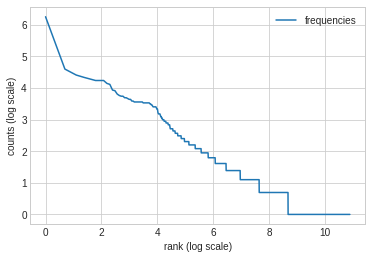

In [14]:
counts = np.load(DS_ITEM_COUNTS_PATH)['y']
print(f'there are {len(counts)} bigrams')
plot_frequencies(counts, 'rank (log scale)', 'counts (log scale)', 'frequencies')

In [15]:
indices = np.argsort(counts)
bigrams = np.load(DS_ITEM_COUNTS_PATH)['x']

print('Top 5 frequent bigrams and their counts:')
print(list(zip(bigrams[indices[-5:]], counts[indices[-5:]])))

print('Bottom 5 frequent bigrams and their counts:')
print(list(zip(bigrams[indices[:5]], counts[indices[:5]])))

Top 5 frequent bigrams and their counts:
[('1 kings', 72), ('progressive rock', 76), ('traditional knowledge', 82), ('median income', 99), ('external links', 518)]
Bottom 5 frequent bigrams and their counts:
[('forbidden love', 1), ('der rotgelbe', 1), ('der krönende', 1), ('der austrucknende', 1), ('der hoffende', 1)]


# Evaluating original count-min and count-sketch algorithms on data

In [16]:
### count sketch ###

DATA = DS_ITEM_COUNTS_PATH
SAVE ='cmin_wikicorpus' #save_results to path
SEED = 69
N_HASHES = [1,2,3,4] 
SPACE_LIST = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.2,1.4,1.6,1.8,2,3,4] #in MB
N_WORKERS = 22 #n_processes used 
DATA_NAME ='wikicorpus' # determines which script for loading counts is used
COUNT_SKETCH = True

In [17]:
cme = CountMinEvaluation(space_list=SPACE_LIST, n_hashes_list=N_HASHES,
                        save=SAVE, 
                        n_workers= N_WORKERS,
                        data_name=DATA_NAME,
                        data=DATA,
                        count_sketch=COUNT_SKETCH,
                        seed=SEED)
cme.run()

statistics for nlp/data/0.1%_wikicorpus_2-grams.npz
data #: 54113, shape (54113,)
positive ratio: 1.25465, max 518.000000, min 1.000000


count_sketch: # hashes 1, # buckets 175000 - loss 0.33	 time: 3.60 sec
count_sketch: # hashes 1, # buckets 500000 - loss 0.12	 time: 3.60 sec
count_sketch: # hashes 1, # buckets 75000 - loss 0.69	 time: 3.64 sec
count_sketch: # hashes 1, # buckets 350000 - loss 0.17	 time: 3.63 sec
count_sketch: # hashes 1, # buckets 250000 - loss 0.24	 time: 3.68 sec
count_sketch: # hashes 1, # buckets 400000 - loss 0.15	 time: 3.67 sec
count_sketch: # hashes 1, # buckets 100000 - loss 0.54	 time: 3.70 sec
count_sketch: # hashes 1, # buckets 300000 - loss 0.20	 time: 3.70 sec
count_sketch: # hashes 1, # buckets 150000 - loss 0.38	 time: 3.71 sec
count_sketch: # hashes 1, # buckets 125000 - loss 0.45	 time: 3.72 sec
count_sketch: # hashes 1, # buckets 750000 - loss 0.08	 time: 3.71 sec
count_sketch: # hashes 1, # buckets 25000 - loss 1.53	 time: 3.75 sec
count_sketch

In [18]:
### count min ###

COUNT_SKETCH = False

cme = CountMinEvaluation(space_list=SPACE_LIST, n_hashes_list=N_HASHES,
                        save=SAVE, 
                        n_workers= N_WORKERS,
                        data_name=DATA_NAME,
                        data=DATA,
                        count_sketch=COUNT_SKETCH,
                        seed=SEED)
cme.run()

statistics for nlp/data/0.1%_wikicorpus_2-grams.npz
data #: 54113, shape (54113,)
positive ratio: 1.25465, max 518.000000, min 1.000000


count_min: # hashes 1, # buckets 50000 - loss 1.33	 time: 1.07 sec
count_min: # hashes 1, # buckets 225000 - loss 0.29	 time: 1.06 sec
count_min: # hashes 1, # buckets 175000 - loss 0.37	 time: 1.07 sec
count_min: # hashes 1, # buckets 100000 - loss 0.65	 time: 1.09 seccount_min: # hashes 1, # buckets 75000 - loss 0.89	 time: 1.09 seccount_min: # hashes 1, # buckets 25000 - loss 2.66	 time: 1.09 sec


count_min: # hashes 1, # buckets 250000 - loss 0.26	 time: 1.09 seccount_min: # hashes 1, # buckets 150000 - loss 0.44	 time: 1.10 sec

count_min: # hashes 1, # buckets 400000 - loss 0.16	 time: 1.09 sec
count_min: # hashes 1, # buckets 350000 - loss 0.18	 time: 1.09 sec
count_min: # hashes 1, # buckets 125000 - loss 0.52	 time: 1.11 sec
count_min: # hashes 1, # buckets 200000 - loss 0.32	 time: 1.12 sec
count_min: # hashes 1, # buckets 300000 - loss 0.

# Train estimation model

In [19]:

targets, preds = train_simple_model(config={
            'ds_name': 'wikicorpus',
            'embed_type': 'CharNGram',
            'embed_dim': 100,
            'op': 'concat',
            'n': 2,
            "limit_prop": 0.001,
            'num_workers': 10,
            "hidden_dim": 128,
            "dropout_prob": 0.0,
            "optim": Adam,
            "learning_rate": 0.0001,
            "batch_size": 128
            },
        args={
            # 'gpus': 4,
            'max_epochs': 60
            })

Global seed set to 123
GPU available: True, used: False
TPU available: None, using: 0 TPU cores




HYPERPARAMS
-----------
{'args': {'max_epochs': 60}}
{'config': {'batch_size': 128,
            'dropout_prob': 0.0,
            'ds_name': 'wikicorpus',
            'embed_dim': 100,
            'embed_type': 'CharNGram',
            'hidden_dim': 128,
            'learning_rate': 0.0001,
            'limit_prop': 0.001,
            'n': 2,
            'num_workers': 10,
            'op': 'concat',
            'optim': <class 'torch.optim.adam.Adam'>}}


Loading features from: 
/data/home/daniel_nlp/learning-ds/nlp/data/0.1%_wikicorpus_2-grams_concat_CharNGram.100_features.npz


/data/home/daniel_nlp/learning-ds/.env/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
54113it [00:01, 46684.11it/s]


Loading features from: 
/data/home/daniel_nlp/learning-ds/nlp/data/0.1%_wikicorpus_2-grams_concat_CharNGram.100_features.npz


54113it [00:01, 54058.35it/s]

  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | l1        | Linear  | 25.7 K
2 | l2        | Linear  | 129   
3 | dropout   | Dropout | 0     
--------------------------------------
25.9 K    Trainable params
0         Non-trainable params
25.9 K    Total params
0.103     Total estimated model params size (MB)


Epoch 0:  57%|█████▋    | 170/297 [00:01<00:01, 85.67it/s, loss=0.128, v_num=2]
Validating: 0it [00:00, ?it/s]
Epoch 1:  57%|█████▋    | 170/297 [00:02<00:01, 82.62it/s, loss=0.127, v_num=2] 
Validating: 0it [00:00, ?it/s]
Epoch 2:  57%|█████▋    | 170/297 [00:02<00:01, 81.63it/s, loss=0.112, v_num=2] 
Validating: 0it [00:00, ?it/s]
Epoch 3:  57%|█████▋    | 170/297 [00:01<00:01, 85.68it/s, loss=0.11, v_num=2]  
Validating: 0it [00:00, ?it/s]
Epoch 4:  57%|█████▋    | 170/297 [00:02<00:01, 83.97it/s, loss=0.109, v_num=2] 
Validating: 0it [00:00, ?it/s]
Epoch 5:  57%|█████▋    | 170/297 [00:01<00:01, 87.56it/s, loss=0.108, v_num=2] 
Validating: 0it [00:00, ?it/s]
Epoch 6:  57%|█████▋    | 170/297 [00:01<00:01, 85.99it/s, loss=0.107, v_num=2] 
Validating: 0it [00:00, ?it/s]
Epoch 7:  57%|█████▋    | 170/297 [00:01<00:01, 87.77it/s, loss=0.107, v_num=2] 
Validating: 0it [00:00, ?it/s]
Epoch 8:  57%|█████▋    | 170/297 [00:01<00:01, 87.31it/s, loss=0.106, v_num=2] 
Validating: 0it [00:00, 

Epoch 13:  57%|█████▋    | 170/297 [00:02<00:01, 83.90it/s, loss=0.102, v_num=2] 
Validating: 0it [00:00, ?it/s]
Epoch 14:  57%|█████▋    | 170/297 [00:01<00:01, 86.40it/s, loss=0.101, v_num=2] 
Validating: 0it [00:00, ?it/s]
Epoch 15:  57%|█████▋    | 170/297 [00:01<00:01, 88.95it/s, loss=0.101, v_num=2] 
Validating: 0it [00:00, ?it/s]
Epoch 16:  57%|█████▋    | 170/297 [00:02<00:01, 82.83it/s, loss=0.1, v_num=2]   
Validating: 0it [00:00, ?it/s]
Epoch 17:  57%|█████▋    | 170/297 [00:02<00:01, 82.70it/s, loss=0.0992, v_num=2]
Validating: 0it [00:00, ?it/s]
Epoch 18:  57%|█████▋    | 170/297 [00:01<00:01, 85.97it/s, loss=0.0985, v_num=2] 
Validating: 0it [00:00, ?it/s]
Epoch 19:  57%|█████▋    | 170/297 [00:02<00:01, 81.89it/s, loss=0.0977, v_num=2] 
Validating: 0it [00:00, ?it/s]
Epoch 20:  57%|█████▋    | 170/297 [00:02<00:01, 82.30it/s, loss=0.097, v_num=2]  
Validating: 0it [00:00, ?it/s]
Epoch 21:  57%|█████▋    | 170/297 [00:02<00:01, 84.98it/s, loss=0.0963, v_num=2]
Validating:

Epoch 27:  57%|█████▋    | 170/297 [00:02<00:01, 84.08it/s, loss=0.092, v_num=2]  
Validating: 0it [00:00, ?it/s]
Epoch 28:  57%|█████▋    | 170/297 [00:02<00:01, 83.08it/s, loss=0.0912, v_num=2]
Validating: 0it [00:00, ?it/s]
Epoch 29:  57%|█████▋    | 170/297 [00:02<00:01, 82.57it/s, loss=0.0905, v_num=2] 
Validating: 0it [00:00, ?it/s]
Epoch 30:  57%|█████▋    | 170/297 [00:01<00:01, 85.80it/s, loss=0.0898, v_num=2] 
Validating: 0it [00:00, ?it/s]
Epoch 31:  57%|█████▋    | 170/297 [00:02<00:01, 77.75it/s, loss=0.0891, v_num=2] 
Validating: 0it [00:00, ?it/s]
Epoch 32:  57%|█████▋    | 170/297 [00:01<00:01, 87.45it/s, loss=0.0884, v_num=2] 
Validating: 0it [00:00, ?it/s]
Epoch 33:  57%|█████▋    | 170/297 [00:02<00:01, 84.01it/s, loss=0.0877, v_num=2] 
Validating: 0it [00:00, ?it/s]
Epoch 34:  57%|█████▋    | 170/297 [00:01<00:01, 87.25it/s, loss=0.087, v_num=2]  
Validating: 0it [00:00, ?it/s]
Epoch 35:  57%|█████▋    | 170/297 [00:02<00:01, 80.31it/s, loss=0.0863, v_num=2]
Validat

Epoch 40:  57%|█████▋    | 170/297 [00:02<00:01, 82.99it/s, loss=0.0831, v_num=2] 
Validating: 0it [00:00, ?it/s]
Epoch 41:  57%|█████▋    | 170/297 [00:02<00:01, 80.63it/s, loss=0.0825, v_num=2] 
Validating: 0it [00:00, ?it/s]
Epoch 42:  57%|█████▋    | 170/297 [00:02<00:01, 80.66it/s, loss=0.0818, v_num=2] 
Validating: 0it [00:00, ?it/s]
Epoch 43:  57%|█████▋    | 170/297 [00:02<00:01, 83.02it/s, loss=0.0812, v_num=2] 
Validating: 0it [00:00, ?it/s]
Epoch 44:  57%|█████▋    | 170/297 [00:01<00:01, 94.79it/s, loss=0.0805, v_num=2] 
Validating: 0it [00:00, ?it/s]
Epoch 45:  57%|█████▋    | 170/297 [00:02<00:01, 78.37it/s, loss=0.0799, v_num=2] 
Validating: 0it [00:00, ?it/s]
Epoch 46:  57%|█████▋    | 170/297 [00:01<00:01, 86.34it/s, loss=0.0793, v_num=2] 
Validating: 0it [00:00, ?it/s]
Epoch 47:  57%|█████▋    | 170/297 [00:02<00:01, 78.87it/s, loss=0.0787, v_num=2] 
Validating: 0it [00:00, ?it/s]
Epoch 48:  57%|█████▋    | 170/297 [00:02<00:01, 81.55it/s, loss=0.0781, v_num=2] 
Valid

Epoch 53:  57%|█████▋    | 170/297 [00:01<00:01, 85.76it/s, loss=0.0751, v_num=2] 
Validating: 0it [00:00, ?it/s]
Epoch 54:  57%|█████▋    | 170/297 [00:02<00:01, 81.03it/s, loss=0.0746, v_num=2] 
Validating: 0it [00:00, ?it/s]
Epoch 55:  57%|█████▋    | 170/297 [00:02<00:01, 83.71it/s, loss=0.074, v_num=2]  
Validating: 0it [00:00, ?it/s]
Epoch 56:  57%|█████▋    | 170/297 [00:02<00:01, 79.15it/s, loss=0.0734, v_num=2]
Validating: 0it [00:00, ?it/s]
Epoch 57:  57%|█████▋    | 170/297 [00:02<00:01, 84.61it/s, loss=0.0729, v_num=2] 
Validating: 0it [00:00, ?it/s]
Epoch 58:  57%|█████▋    | 170/297 [00:02<00:01, 82.43it/s, loss=0.0723, v_num=2] 
Validating: 0it [00:00, ?it/s]
Epoch 59:  57%|█████▋    | 170/297 [00:01<00:01, 88.55it/s, loss=0.0718, v_num=2] 
Validating: 0it [00:00, ?it/s]
Epoch 59: 100%|██████████| 297/297 [00:02<00:00, 111.05it/s, loss=0.0718, v_num=2]
Loading features from: 
/data/home/daniel_nlp/learning-ds/nlp/data/0.1%_wikicorpus_2-grams_concat_CharNGram.100_features

54113it [00:01, 45167.39it/s]

Testing: 0it [00:00, ?it/s]

Testing: 100%|██████████| 127/127 [00:00<00:00, 180.56it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.09675215184688568}
--------------------------------------------------------------------------------
dumping test train and validation to:
train test valid
dumping test train and validation predictions to:
/data/home/daniel_nlp/learning-ds/nlp/pred_0.1%_wikicorpus_2-grams_concat_CharNGram.100.npz


HYPERPARAMS
-----------
{'args': {'max_epochs': 60}}
{'config': {'batch_size': 128,
            'dropout_prob': 0.0,
            'ds_name': 'wikicorpus',
            'embed_dim': 100,
            'embed_type': 'CharNGram',
            'hidden_dim': 128,
            'learning_rate': 0.0001,
            'limit_prop': 0.001,
            'n': 2,
            'num_workers': 10,
            'op': 'concat',
            'optim': <class 'torch.optim.adam.Adam'>}}




No Skill: ROC AUC=0.50
Learned: ROC AUC=0.77


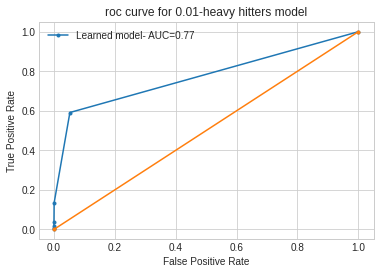

Saving plot...
Done.


<Figure size 432x288 with 0 Axes>

In [20]:
plot_roc(targets=targets, preds=preds, split='test', hh_frac=0.01)

In [21]:
TEST_RESULTS =[f"./nlp/pred_{prec}%_wikicorpus_2-grams_concat_CharNGram.100.npz"]
VALID_RESULTS = [f"./nlp/pred_{prec}%_wikicorpus_2-grams_concat_CharNGram.100.npz"]
TEST_DATA = [f"./nlp/true_{prec}%_wikicorpus_2-grams_concat_CharNGram.100_test.npz"]
VALID_DATA = [f"./nlp/true_{prec}%_wikicorpus_2-grams_concat_CharNGram.100_valid.npz"]
LOOKUP_DATA = [f"./nlp/true_{prec}%_wikicorpus_2-grams_concat_CharNGram.100_train.npz"]
SAVE ='cmin_wikicorpus'
SEED = 69
SPACE_LIST = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.2, 1.4, 1.6, 1.8, 2, 3, 4]
N_HASHES_LIST = [1, 2, 3, 4]
PERFECT_ORDER = False
N_WORKERS = 7
DATA_NAME ='wikicorpus'
COUNT_SKETCH = False

In [ ]:
print('Running: with lookup, count min...')
# with lookup

lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )

lcm.run()

Running: with lookup, count min...
/data/home/daniel_nlp/learning-ds/.env/lib/python3.6/site-packages/ipykernel_launcher.py -f /data/home/daniel_nlp/.local/share/jupyter/runtime/kernel-a89d89df-bab4-4cc8-9b6e-30f238917f37.json

statistics for valid data:
./nlp/true_0.1%_wikicorpus_2-grams_concat_CharNGram.100_valid.npz
data #: 16233, shape (16233,)
positive ratio: 1.29914, max 518.000000, min 1.000000


statistics for test data:
./nlp/true_0.1%_wikicorpus_2-grams_concat_CharNGram.100_test.npz
data #: 16233, shape (16233,)
positive ratio: 1.23274, max 82.000000, min 1.000000


statistics for lookup data:
./nlp/true_0.1%_wikicorpus_2-grams_concat_CharNGram.100_train.npz
data #: 21647, shape (21647,)
positive ratio: 1.23772, max 99.000000, min 1.000000


data loading time: 0.0 sec
	loss_cf 0.00	loss_rd 1.02	loss_avg 1.02
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 20288 - loss 1.02	 time: 0.33 sec
	loss_cf 0.00	loss_rd 1.39	loss_avg 1.39
	# uniq 0 # cm 

lookup_table_count_min: s_cut: 0, # hashes 1, # cm buckets 31706 - loss 0.69	 time: 0.34 sec
	loss_cf 0.00	loss_rd 7.50	loss_avg 7.50
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 4, # cm buckets 1676 - loss 7.50	 time: 0.62 sec
	loss_cf 0.00	loss_rd 1.00	loss_avg 1.00
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 20288 - loss 1.00	 time: 0.34 sec
	loss_cf 0.00	loss_rd 0.25	loss_avg 0.25
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 4, # cm buckets 14176 - loss 0.25	 time: 0.64 sec
	loss_cf 0.00	loss_rd 3.15	loss_avg 3.15
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 1, # cm buckets 6706 - loss 3.15	 time: 0.32 sec
	loss_cf 0.00	loss_rd 0.57	loss_avg 0.57
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 2, # cm buckets 15853 - loss 0.57	 time: 0.44 sec
	loss_cf 0.00	loss_rd 0.32	loss_avg 0.32
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 1, # cm buckets 56706 - loss 

 lookup_table_count_min: s_cut: 0, # hashes 3, # cm buckets 10568 - loss 0.61	 time: 0.54 sec16233

lookup_table_count_min: s_cut: 1, # hashes 4, # cm buckets 5072 - loss 1.67	 time: 0.65 sec
	loss_cf 0.00	loss_rd 0.68	loss_avg 0.68
	# uniq 0 	loss_cf 0.00	loss_rd 4.18	loss_avg 4.18# cm
	# uniq  162330
 # cm lookup_table_count_min: s_cut: 0, # hashes 1, # cm buckets 31706 - loss 0.68	 time: 0.37 sec16233

lookup_table_count_min: s_cut: 0, # hashes 2, # cm buckets 3353 - loss 4.18	 time: 0.45 sec
	loss_cf 0.00	loss_rd 0.11	loss_avg 0.11	loss_cf 0.00	loss_rd 7.55	loss_avg 7.55

	# uniq	# uniq  00  # cm# cm  1623316233

lookup_table_count_min: s_cut: 0, # hashes 2, # cm buckets 40853 - loss 0.11	 time: 0.46 seclookup_table_count_min: s_cut: 0, # hashes 4, # cm buckets 1676 - loss 7.55	 time: 0.66 sec

	loss_cf 0.00	loss_rd 0.23	loss_avg 0.23
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 4, # cm buckets 14176 - loss 0.23	 time: 0.63 sec
	loss_cf 0.00	loss_rd 0.98	loss_avg

lookup_table_count_min: s_cut: 0, # hashes 4, # cm buckets 7926 - loss 0.78	 time: 0.62 sec
	loss_cf 0.00	loss_rd 0.26	loss_avg 0.26
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 1, # cm buckets 81706 - loss 0.26	 time: 0.36 sec
	loss_cf 0.00	loss_rd 0.15	loss_avg 0.15
	# uniq 0 # cm 	loss_cf 0.00	loss_rd 0.11	loss_avg 0.1116233

	# uniq 0 lookup_table_count_min: s_cut: 0, # hashes 1, # cm buckets 131706 - loss 0.15	 time: 0.33 sec	loss_cf 0.00	loss_rd 0.05	loss_avg 0.05# cm

 	# uniq16233 
0 lookup_table_count_min: s_cut: 0, # hashes 2, # cm buckets 40853 - loss 0.11	 time: 0.47 sec# cm
 16233
lookup_table_count_min: s_cut: 0, # hashes 3, # cm buckets 35568 - loss 0.05	 time: 0.55 sec
	loss_cf 0.00	loss_rd 0.09	loss_avg 0.09
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 4, # cm buckets 20426 - loss 0.09	 time: 0.63 sec
	loss_cf 0.00	loss_rd 0.25	loss_avg 0.25
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 4, # cm buckets 14176 - los

	loss_cf 0.00	loss_rd 0.02	loss_avg 0.02
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 4, # cm buckets 32926 - loss 0.02	 time: 0.62 sec
	loss_cf 0.00	loss_rd 0.02	loss_avg 0.02
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 3, # cm buckets 52235 - loss 0.02	 time: 0.53 sec
	loss_cf 0.00	loss_rd 0.01	loss_avg 0.01
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 4, # cm buckets 45426 - loss 0.01	 time: 0.62 sec
	loss_cf 0.00	loss_rd 0.16	loss_avg 0.16
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 1, # cm buckets 131706 - loss 0.16	 time: 0.33 sec
	loss_cf 0.00	loss_rd 0.05	loss_avg 0.05
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 2, # cm buckets 65853 - loss 0.05	 time: 0.43 sec
	loss_cf 0.00	loss_rd 0.07	loss_avg 0.07
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 2, # cm buckets 53353 - loss 0.07	 time: 0.43 sec
	loss_cf 0.00	loss_rd 0.05	loss_avg 0.05
	# uniq 0 # cm 16233
lookup_

lookup_table_count_min: s_cut: 0, # hashes 2, # cm buckets 53353 - loss 0.07	 time: 0.43 sec
	loss_cf 0.00	loss_rd 0.10	loss_avg 0.10
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 3, # cm buckets 27235 - loss 0.10	 time: 0.52 sec
	loss_cf 0.00	loss_rd 0.17	loss_avg 0.17
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 1, # cm buckets 106706 - loss 0.17	 time: 0.33 sec
	loss_cf 0.00	loss_rd 0.18	loss_avg 0.18
	# uniq 0 # cm 16233
	loss_cf 0.00	loss_rd 0.02	loss_avg 0.02
lookup_table_count_min: s_cut: 0, # hashes 1, # cm buckets 156706 - loss 0.18	 time: 0.36 sec	# uniq
 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 4, # cm buckets 32926 - loss 0.02	 time: 0.60 sec
	loss_cf 0.00	loss_rd 0.02	loss_avg 0.02
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 3, # cm buckets 52235 - loss 0.02	 time: 0.57 sec
	loss_cf 0.00	loss_rd 0.17	loss_avg 0.17
	# uniq 0	loss_cf 0.00	loss_rd 0.05	loss_avg 0.05	loss_cf 0.00	loss_rd 0.01	loss_avg 0.01

 16233lookup_table_count_min: s_cut: 0, # hashes 2, # cm buckets 78353 - loss 0.03	 time: 0.45 sec

lookup_table_count_min: s_cut: 0, # hashes 3, # cm buckets 60568 - loss 0.01	 time: 0.54 sec
lookup_table_count_min: s_cut: 0, # hashes 3, # cm buckets 85568 - loss 0.00	 time: 0.54 sec
	loss_cf 0.00	loss_rd 0.07	loss_avg 0.07
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 2, # cm buckets 103353 - loss 0.07	 time: 0.47 sec
	loss_cf 0.00	loss_rd 0.01	loss_avg 0.01
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 3, # cm buckets 60568 - loss 0.01	 time: 0.56 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 4, # cm buckets 51676 - loss 0.00	 time: 0.65 sec
	loss_cf 0.00	loss_rd 0.07	loss_avg 0.07
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 1, # cm buckets 306706 - loss 0.07	 time: 0.34 sec
	loss_cf 0.00	loss_rd 0.01	loss_avg 0.01
	loss_cf 0.00	loss_rd 0.10	loss_avg 0.10	# uniq 
0	

lookup_table_count_min: s_cut: 0, # hashes 3, # cm buckets 68902 - loss 0.01	 time: 0.54 sec
	loss_cf 0.00	loss_rd 0.07	loss_avg 0.07
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 1, # cm buckets 306706 - loss 0.07	 time: 0.36 sec
	loss_cf 0.00	loss_rd 0.02	loss_avg 0.02	loss_cf 0.00	loss_rd 0.01	loss_avg 0.01

	# uniq	# uniq  00  # cm# cm  1623316233

lookup_table_count_min: s_cut: 0, # hashes 3, # cm buckets 85568 - loss 0.01	 time: 0.57 seclookup_table_count_min: s_cut: 0, # hashes 2, # cm buckets 128353 - loss 0.02	 time: 0.45 sec

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 4, # cm buckets 76676 - loss 0.00	 time: 0.64 sec
	loss_cf 0.00	loss_rd 0.01	loss_avg 0.01
	# uniq	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
 	# uniq0  0# cm  # cm16233 
16233
lookup_table_count_min: s_cut: 0, # hashes 3, # cm buckets 60568 - loss 0.01	 time: 0.54 sec
lookup_table_count_min: s_cut: 0, # hashes 3, # cm buckets 118902 - 

	loss_cf 0.00	loss_rd 0.07	loss_avg 0.07
	# uniq 0 # cm 16233
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00lookup_table_count_min: s_cut: 0, # hashes 1, # cm buckets 256706 - loss 0.07	 time: 0.32 sec

	# uniq	loss_cf 0.00	loss_rd 0.01	loss_avg 0.01 
0	# uniq # cm  162330
 # cm lookup_table_count_min: s_cut: 0, # hashes 4, # cm buckets 76676 - loss 0.00	 time: 0.64 sec16233

lookup_table_count_min: s_cut: 0, # hashes 2, # cm buckets 178353 - loss 0.01	 time: 0.44 sec
	loss_cf 0.00	loss_rd 0.01	loss_avg 0.01
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 3, # cm buckets 68902 - loss 0.01	 time: 0.52 sec
	loss_cf 0.00	loss_rd 0.05	loss_avg 0.05
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 1, # cm buckets 356706 - loss 0.05	 time: 0.33 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	# uniq 0 	loss_cf 0.00	loss_rd 0.01	loss_avg 0.01# cm
 	# uniq16233 
0lookup_table_count_min: s_cut: 0, # hashes 3, # cm buckets 85568 - loss 0.00	 time: 0.52 sec # cm
 16233
looku

lookup_table_count_min: s_cut: 0, # hashes 3, # cm buckets 135568 - loss 0.00	 time: 0.53 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	# uniq	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00 
0	# uniq  # cm0  # cm16233 
16233
lookup_table_count_min: s_cut: 0, # hashes 4, # cm buckets 114176 - loss 0.00	 time: 0.64 sec
lookup_table_count_min: s_cut: 0, # hashes 2, # cm buckets 228353 - loss 0.00	 time: 0.45 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 3, # cm buckets 235568 - loss 0.00	 time: 0.54 sec
	loss_cf 0.00	loss_rd 0.01	loss_avg 0.01
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 2, # cm buckets 178353 - loss 0.01	 time: 0.46 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 4, # cm buckets 89176 - loss 0.00	 time: 0.64 sec
	loss_cf 0.00	loss_rd 0.01	loss_avg 0.01
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 2, # cm buckets 178353

lookup_table_count_min: s_cut: 0, # hashes 1, # cm buckets 406706 - loss 0.06	 time: 0.33 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 4, # cm buckets 239176 - loss 0.00	 time: 0.65 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 3, # cm buckets 318902 - loss 0.00	 time: 0.55 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 3, # cm buckets 135568 - loss 0.00	 time: 0.54 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	# uniq 0 # cm 	loss_cf 0.00	loss_rd 0.00	loss_avg 0.0016233

	# uniq lookup_table_count_min: s_cut: 0, # hashes 3, # cm buckets 235568 - loss 0.00	 time: 0.54 sec0
 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 2, # cm buckets 228353 - loss 0.00	 time: 0.44 sec
	loss_cf 0.00	loss_rd 0.01	loss_avg 0.01
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 2, # cm buckets 20335

lookup_table_count_min: s_cut: 0, # hashes 2, # cm buckets 203353 - loss 0.01	 time: 0.45 sec	# uniq
 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 3, # cm buckets 152235 - loss 0.00	 time: 0.54 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 2, # cm buckets 353353 - loss 0.00	 time: 0.46 sec
	loss_cf 0.00	loss_rd 0.03	loss_avg 0.03
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 1, # cm buckets 706706 - loss 0.03	 time: 0.34 sec
	loss_cf 0.00	loss_rd 0.05	loss_avg 0.05
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 1, # cm buckets 406706 - loss 0.05	 time: 0.35 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 4, # cm buckets 239176 - loss 0.00	 time: 0.65 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 3, # cm buckets 135568 - loss 0.00	 time: 0.55 sec
	loss_cf 0.

	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 4, # cm buckets 89176 - loss 0.00	 time: 0.67 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 4, # cm buckets 101676 - loss 0.00	 time: 0.65 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 4, # cm buckets 114176 - loss 0.00	 time: 0.63 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 4, # cm buckets 176676 - loss 0.00	 time: 0.64 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	# uniq 0 # cm 16233
lookup_table_count_min: s_cut: 0, # hashes 4, # cm buckets 239176 - loss 0.00	 time: 0.60 sec
/data/home/daniel_nlp/learning-ds/.env/lib/python3.6/site-packages/ipykernel_launcher.py -f /data/home/daniel_nlp/.local/share/jupyter/runtime/kernel-a89d89df-bab4-4cc8-9b6e-30f238917f37.json
statistics for valid data:
./nlp/true_0.1%_wikicorpus_2-grams_concat_C

In [ ]:
print('Running: no lookup, only using learned model count min...')

LOOKUP_DATA2 = None
PERFECT_ORDER = False

lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA2,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )
lcm.run()

In [ ]:
print('Running: perfect oracle... only using learned model count min...')

LOOKUP_DATA3=None
PERFECT_ORDER=True

lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA3,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )
lcm.run()

# Plot count min

In [ ]:
ALGO = 'Count-Min'
COUNT_MIN = 'param_results/count_min/cmin_wikicorpus.npz'
LEARNED = ['param_results/cutoff_count_min_param/cmin_wikicorpus_test.npz']
PERFECT = 'param_results/cutoff_count_min_param_perfect/cmin_wikicorpus_test.npz'
LOOKUP_TABLE ='param_results/lookup_table_count_min/cmin_wikicorpus_test.npz' 
MODEL_NAMES = ["Learned Count-Min (NNet)"]
TITLE = 'wikicorpus'
MODEL_SIZES = [0.103]
LOOKUP_SIZE = [0.0035]
X_LIM = [0,2]
Y_LIM = [0,20]

plvs = PlotLossVsSpace(
        count_min=COUNT_MIN,
        learned_cmin=LEARNED,
        model_names=MODEL_NAMES,
        perfect_ccm=PERFECT,
        lookup_table_ccm=LOOKUP_TABLE,
        model_sizes=MODEL_SIZES,
        lookup_size=LOOKUP_SIZE,
        x_lim=X_LIM,
        y_lim=Y_LIM,
        title=TITLE,
        algo=ALGO,
    )

plvs.run()

In [ ]:

print('Running: with lookup, count sketch...')
COUNT_SKETCH = True
PERFECT_ORDER = False
# with lookup

lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )

lcm.run()

In [ ]:
print('Running: no lookup, only using learned model count sketch...')

LOOKUP_DATA2 = None
PERFECT_ORDER = False

lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA2,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )
lcm.run()

In [ ]:
print('Running: perfect oracle... only using learned model count sketch...')

LOOKUP_DATA3=None
PERFECT_ORDER=True

lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA3,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )
lcm.run()

In [ ]:
ALGO = 'Count-Min'
COUNT_MIN = 'param_results/count_sketch/cmin_wikicorpus.npz'
LEARNED = ['param_results/cutoff_count_sketch_param/cmin_wikicorpus_test.npz']
PERFECT = 'param_results/cutoff_count_sketch_param_perfect/cmin_wikicorpus_test.npz'
LOOKUP_TABLE ='param_results/lookup_table_count_sketch/cmin_wikicorpus_test.npz' 
MODEL_NAMES = ["Learned Count-Sketch (NNet)"]
TITLE = 'wikicorpus'
MODEL_SIZES = [0.103]
LOOKUP_SIZE = [0.0035]
X_LIM = [0,2]
Y_LIM = [0,20]

plvs = PlotLossVsSpace(
        count_min=COUNT_MIN,
        learned_cmin=LEARNED,
        model_names=MODEL_NAMES,
        perfect_ccm=PERFECT,
        lookup_table_ccm=LOOKUP_TABLE,
        model_sizes=MODEL_SIZES,
        lookup_size=LOOKUP_SIZE,
        x_lim=X_LIM,
        y_lim=Y_LIM,
        title=TITLE,
        algo=ALGO,
    )

plvs.run()